In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/MS983/Datasets/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import optuna
from optuna.integration import TFKerasPruningCallback

# Load ISOT dataset
ISOTdf = pd.read_csv('ISOT/FullyCleanISOT.csv')[['text', 'label']].dropna()
texts = ISOTdf['text'].tolist()
labels = ISOTdf['label'].values

# Split dataset into train, validation, and test sets
X_temp_texts, X_test_texts, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.20, random_state=42, stratify=labels
)
X_train_texts, X_val_texts, y_train, y_val = train_test_split(
    X_temp_texts, y_temp, test_size=0.20, random_state=42, stratify=y_temp
)

# Fit tokenizer on training texts
max_words = 10000
max_len   = 300
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

# Convert texts to sequences and pad them
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train_texts), maxlen=max_len)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_texts),   maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test_texts),  maxlen=max_len)

# Create embedding matrix using GloVe embeddings
embedding_dim = 300
GLOVE_PATH = "glove.2024.dolma.300d/dolma_300_2024_1.2M.100_combined.txt"

# Load GloVe embeddings
embeddings_index = {}
with open(GLOVE_PATH, encoding='utf-8') as f:
    for line in f:
        parts = line.split()
        word = parts[0]
        vec  = np.asarray(parts[1:], dtype='float32')
        embeddings_index[word] = vec

# Create embedding matrix
embedding_matrix = np.random.normal(scale=0.01, size=(max_words, embedding_dim)).astype("float32")
for word, idx in tokenizer.word_index.items():
    if idx < max_words:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec

/content/drive/MyDrive/MS983/Datasets


In [ ]:
# Define the model creation function for Optuna optimization
def create_model(trial):
    lstm_units = trial.suggest_categorical("lstm_units", [64, 128, 256]) # LSTM units
    dense_units = trial.suggest_categorical("dense_units", [32, 64, 128]) # Dense layer units
    dropout_rate = trial.suggest_float("dropout", 0.2, 0.5) # Dropout rate
    learning_rate = trial.suggest_float("lr", 1e-5, 1e-3, log=True) # Learning rate

    # Build the model
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False), # Embedding layer
        Bidirectional(LSTM(lstm_units, return_sequences=False)), # Bidirectional LSTM layer
        Dropout(dropout_rate), # Dropout layer
        Dense(dense_units, activation='relu'), # Dense layer
        Dropout(dropout_rate), # Another Dropout layer
        Dense(1, activation='sigmoid') # Output layer for binary classification
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

# Define the objective function for Optuna
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128]) # Batch size
    max_epochs = trial.suggest_int("max_epochs", 3, 8) # Maximum epochs

    # Create the model
    model = create_model(trial)

    # Initialize callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)
    prune = TFKerasPruningCallback(trial, monitor="val_accuracy")

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[early_stop, lr_schedule, prune],
        verbose=0
    )

    return max(history.history['val_accuracy'])

# Run the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best params:", study.best_trial.params)



[I 2025-08-15 16:39:20,144] A new study created in memory with name: no-name-e834f9ca-68dd-43ab-bb7e-193dd07c7d5f
[I 2025-08-15 16:41:52,927] Trial 0 finished with value: 0.9635644555091858 and parameters: {'batch_size': 32, 'max_epochs': 7, 'lstm_units': 256, 'dense_units': 32, 'dropout': 0.34384147187222924, 'lr': 0.00018675615823916816}. Best is trial 0 with value: 0.9635644555091858.
[I 2025-08-15 16:42:29,922] Trial 1 finished with value: 0.9598926901817322 and parameters: {'batch_size': 128, 'max_epochs': 5, 'lstm_units': 256, 'dense_units': 32, 'dropout': 0.27982187485160154, 'lr': 4.631053653297934e-05}. Best is trial 0 with value: 0.9635644555091858.
[I 2025-08-15 16:43:55,760] Trial 2 finished with value: 0.9432283639907837 and parameters: {'batch_size': 32, 'max_epochs': 7, 'lstm_units': 128, 'dense_units': 64, 'dropout': 0.45941516072099764, 'lr': 0.0003177905409671583}. Best is trial 0 with value: 0.9635644555091858.
[I 2025-08-15 16:44:43,126] Trial 3 finished with value:

Best params: {'batch_size': 128, 'max_epochs': 8, 'lstm_units': 64, 'dense_units': 32, 'dropout': 0.25098555582714555, 'lr': 0.0008505357768239972}


In [ ]:
# Get the best parameters from the study
best_params = study.best_trial.params

lstm_units = best_params['lstm_units']
dense_units = best_params['dense_units']
dropout_rate = best_params['dropout']
learning_rate = best_params['lr']
batch_size = best_params['batch_size']
max_epochs = best_params['max_epochs']

# Create the final model with the best parameters
model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

# Compile the model
model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

# Train the model with the best parameters
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['max_epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)],
    verbose=1
)

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8269 - loss: 0.4001 - val_accuracy: 0.9294 - val_loss: 0.1835
Epoch 2/8
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9312 - loss: 0.1886 - val_accuracy: 0.9438 - val_loss: 0.1441
Epoch 3/8
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9549 - loss: 0.1248 - val_accuracy: 0.9607 - val_loss: 0.1083
Epoch 4/8
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9684 - loss: 0.0956 - val_accuracy: 0.9783 - val_loss: 0.0598
Epoch 5/8
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9786 - loss: 0.0637 - val_accuracy: 0.9845 - val_loss: 0.0464
Epoch 6/8
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9829 - loss: 0.0524 - val_accuracy: 0.9856 - val_loss: 0.0409
Epoch 7/8
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9853 - loss: 0.0441 - val_accuracy: 0.9867 - val_loss: 0.0380
Epoch 8/8
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9898 - loss: 0.0316 - val_accuracy: 0.9887 - val

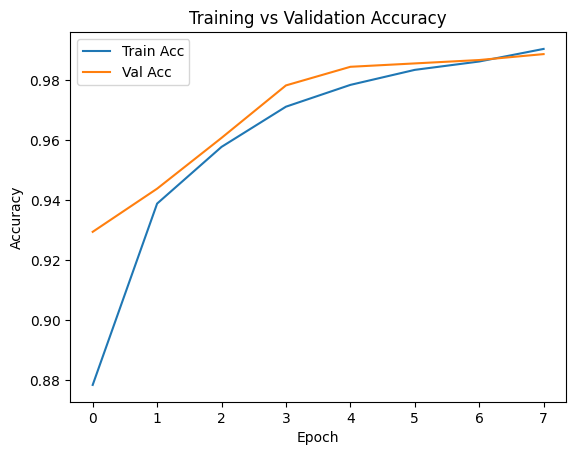

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


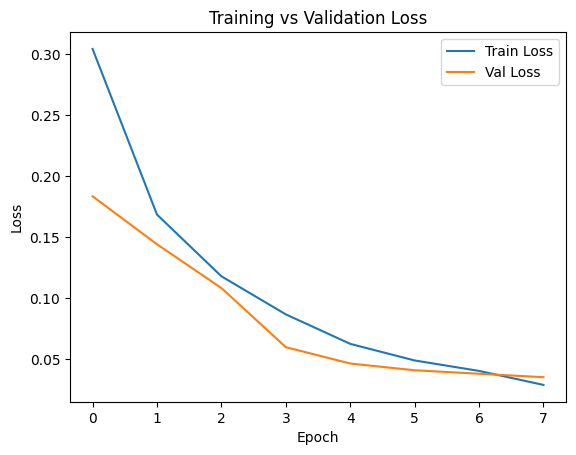

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")


277/277 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9867 - loss: 0.0401
Test Accuracy: 0.9870


In [ ]:
# Test Performance
print("\nTest Performance:")

start_test = time.time() # Start time for test inference

# Compute probabilities and predictions
test_proba = model.predict(X_test, batch_size=16, verbose=0).ravel()
test_pred = (test_proba > 0.5).astype(int)

end_test = time.time() # End time for test inference

test_time = end_test - start_test
test_avg_time = test_time / len(y_test)

print(classification_report(y_test, test_pred))
print(f"Test inference time: {test_time:.4f} seconds")
print(f"Average time per test sample: {test_avg_time:.6f} seconds")


Test Performance:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4568
           1       0.99      0.98      0.99      4284

    accuracy                           0.99      8852
   macro avg       0.99      0.99      0.99      8852
weighted avg       0.99      0.99      0.99      8852

Test inference time: 5.1987 seconds
Average time per test sample: 0.000587 seconds


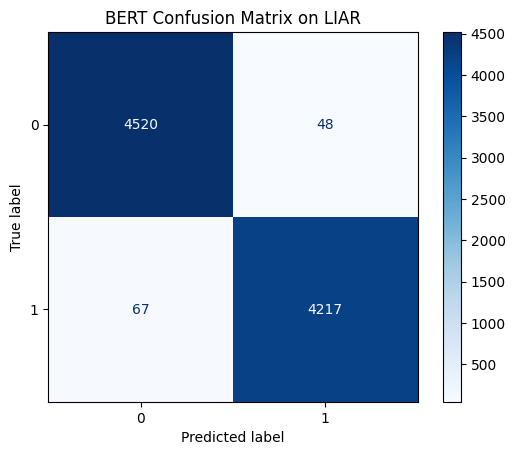

In [ ]:
# Compute confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, test_pred)

# Display confusion matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
cm_display.plot(cmap="Blues", values_format='d')
plt.title("LSTM Confusion Matrix on ISOT")
plt.show()

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/MS983/Models/ISOT_LSTM.h5')